# PSB injection bump in Xsuite - acceleration and RF

In [1]:
%matplotlib notebook

In [2]:
# Import modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import xtrack as xt
import xpart as xp
import xdeps as xd

from cpymad.madx import Madx

/Users/giadarol/xsuite_packages/xtrack/xtrack/progress_indicator.py:90: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


###  Load line from previous notebook

In [3]:
# Reload
line = xt.Line.from_json('psb_03_with_chicane_corrected.json')
line.build_tracker()

Loading line from dict:   0%|          | 0/1227 [00:00<?, ?it/s]

Done loading line from dict.           
Found suitable prebuilt kernel `default_only_xtrack`.


### Load momentum and RF functions

In [4]:
fname = 'Ramp_and_RF_functions.dat'
df = pd.read_csv(fname, sep='\t', skiprows=2,
    names=['t_s', 'E_kin_GeV', 'V1_MV', 'phi1_rad', 'V2_MV', 'phi2_rad'])

In [5]:
df.head()

,t_s,E_kin_GeV,V1_MV,phi1_rad,V2_MV,phi2_rad
0,0.0000,0.16,0.002934,3.141593,-0.002201,3.134638
1,0.0001,0.16,0.002930,3.141593,-0.002198,3.135402
2,0.0002,0.16,0.002926,3.141593,-0.002195,3.136165
3,0.0003,0.16,0.002922,3.141593,-0.002192,3.136928
4,0.0004,0.16,0.002918,3.141593,-0.002189,3.137691


### Set line energy program

In [6]:
ep = xt.EnergyProgram(t_s=df['t_s'].values, kinetic_energy0=df['E_kin_GeV'].values*1e9)

In [7]:
line.energy_program = ep

### RF frequency programs

In [8]:
t_s = df['t_s'].values
freq_rev = line.energy_program.get_frev_at_t_s(t_s) # Revolution frequency at selected times
freq_rev

LinkedArrayCpu([ 991965.96799408,  991965.96799408,  991965.96799408,
                 991965.96799408,  991965.96799408,  991965.96799408,
                 991965.96799408,  991968.8474556 ,  991976.6316743 ,
                 991989.29600542,  992006.79125417,  992029.65365908,
                 992057.41888386,  992089.84210106,  992126.89795271,
                 992168.9512194 ,  992215.85422356,  992267.21532659,
                 992323.00868264,  992383.45213816,  992448.66578431,
                 992518.16016164,  992591.86026016,  992669.8615624 ,
                 992752.57606971,  992839.34365256,  992930.13771033,
                 993024.93155797,  993124.23395738,  993227.45796069,
                 993334.52798371,  993445.34408851,  993560.36569049,
                 993679.20067755,  993801.67599721,  993927.7158908 ,
                 994057.60900534,  994191.23069788,  994328.26213523,
                 994468.70031934,  994612.61497501,  994760.19695098,
                 994

In [9]:
# Create interpolating functions and variables
line.functions['fun_freq_rev'] = xd.FunctionPieceWiseLinear(x=t_s, y=freq_rev)
line.vars['freq_rev'] = line.functions['fun_freq_rev'](line.vars['t_turn_s'])

# Create variables for first and second harmonics
line.vars['freq_h1'] = line.vars['freq_rev']
line.vars['freq_h2'] = 2 * line.vars['freq_rev']

In [10]:
# Test at 0 ms
line.vars['t_turn_s'] = 0
print(line.vv['freq_h1'], line.vv['freq_h2'])

991965.9679940767 1983931.9359881533


In [11]:
# Test at 5 ms
line.vars['t_turn_s'] = 5e-3
print(line.vv['freq_h1'], line.vv['freq_h2'])

996231.3420558685 1992462.684111737


### RF voltage and phase programs

In [12]:
V1_MV = df.V1_MV.values # comes from the file
V2_MV = df.V2_MV.values # comes from the file

# Shift phases to have the beam centered around zero
phi1_rad = df.phi1_rad.values - np.pi
phi2_rad = df.phi2_rad.values - np.pi

# Build interpolating functions and variables for voltages
line.functions['fun_volt_mv_h1'] = xd.FunctionPieceWiseLinear(x=t_s, y=V1_MV)
line.functions['fun_volt_mv_h2'] = xd.FunctionPieceWiseLinear(x=t_s, y=V2_MV)
line.vars['volt_mv_h1'] = line.functions['fun_volt_mv_h1'](line.vars['t_turn_s'])
line.vars['volt_mv_h2'] = line.functions['fun_volt_mv_h2'](line.vars['t_turn_s'])

# Build interpolating functions and variables for voltages
line.functions['fun_phi_rad_h1'] = xd.FunctionPieceWiseLinear(x=t_s, y=phi1_rad)
line.functions['fun_phi_rad_h2'] = xd.FunctionPieceWiseLinear(x=t_s, y=phi2_rad)
line.vars['phi_rad_h1'] = line.functions['fun_phi_rad_h1'](line.vars['t_turn_s'])
line.vars['phi_rad_h2'] = line.functions['fun_phi_rad_h2'](line.vars['t_turn_s'])

### Attach variables to cavities

In [13]:
line.element_refs['br1.acwf5l1.1'].voltage = line.vars['volt_mv_h1'] * 1e6
line.element_refs['br1.acwf5l1.2'].voltage = line.vars['volt_mv_h2'] * 1e6

line.element_refs['br1.acwf5l1.1'].lag = line.vars['phi_rad_h1'] * 360 / 2 / np.pi
line.element_refs['br1.acwf5l1.2'].lag = line.vars['phi_rad_h2'] * 360 / 2 / np.pi

line.element_refs['br1.acwf5l1.1'].frequency = line.vars['freq_h1']
line.element_refs['br1.acwf5l1.2'].frequency = line.vars['freq_h2']

### Characterize with twiss

In [22]:
t_check = np.linspace(0, 50e-3, 200)

t_rev = []
gamma0 = []
f_h1 = []
f_h2 = []
lag_h1 = []
lag_h2 = []
volt_h1 = []
volt_h2 = []
x_at_foil = []
for ii, tt in enumerate(t_check):
    print(f'Computing twiss at t_s = {tt:.4} s    ', end='\r', flush=True)
    line.vars['t_turn_s'] = tt
    tw = line.twiss(method='4d')
    t_rev.append(tw.T_rev0)
    gamma0.append(tw.gamma0)
    f_h1.append(line['br1.acwf5l1.1'].frequency)
    f_h2.append(line['br1.acwf5l1.2'].frequency)
    lag_h1.append(line['br1.acwf5l1.1'].lag)
    lag_h2.append(line['br1.acwf5l1.2'].lag)
    volt_h1.append(line['br1.acwf5l1.1'].voltage)
    volt_h2.append(line['br1.acwf5l1.2'].voltage)
    x_at_foil.append(tw['x', 'bi1.tstr1l1_entry'])


line.vars['t_turn_s'] = 0

gamma0 = np.array(gamma0)
f_h1 = np.array(f_h1)
f_h2 = np.array(f_h2)
e_kin_gev = 1e-9 * xt.PROTON_MASS_EV * (gamma0 - 1)

<IPython.core.display.Javascript object>


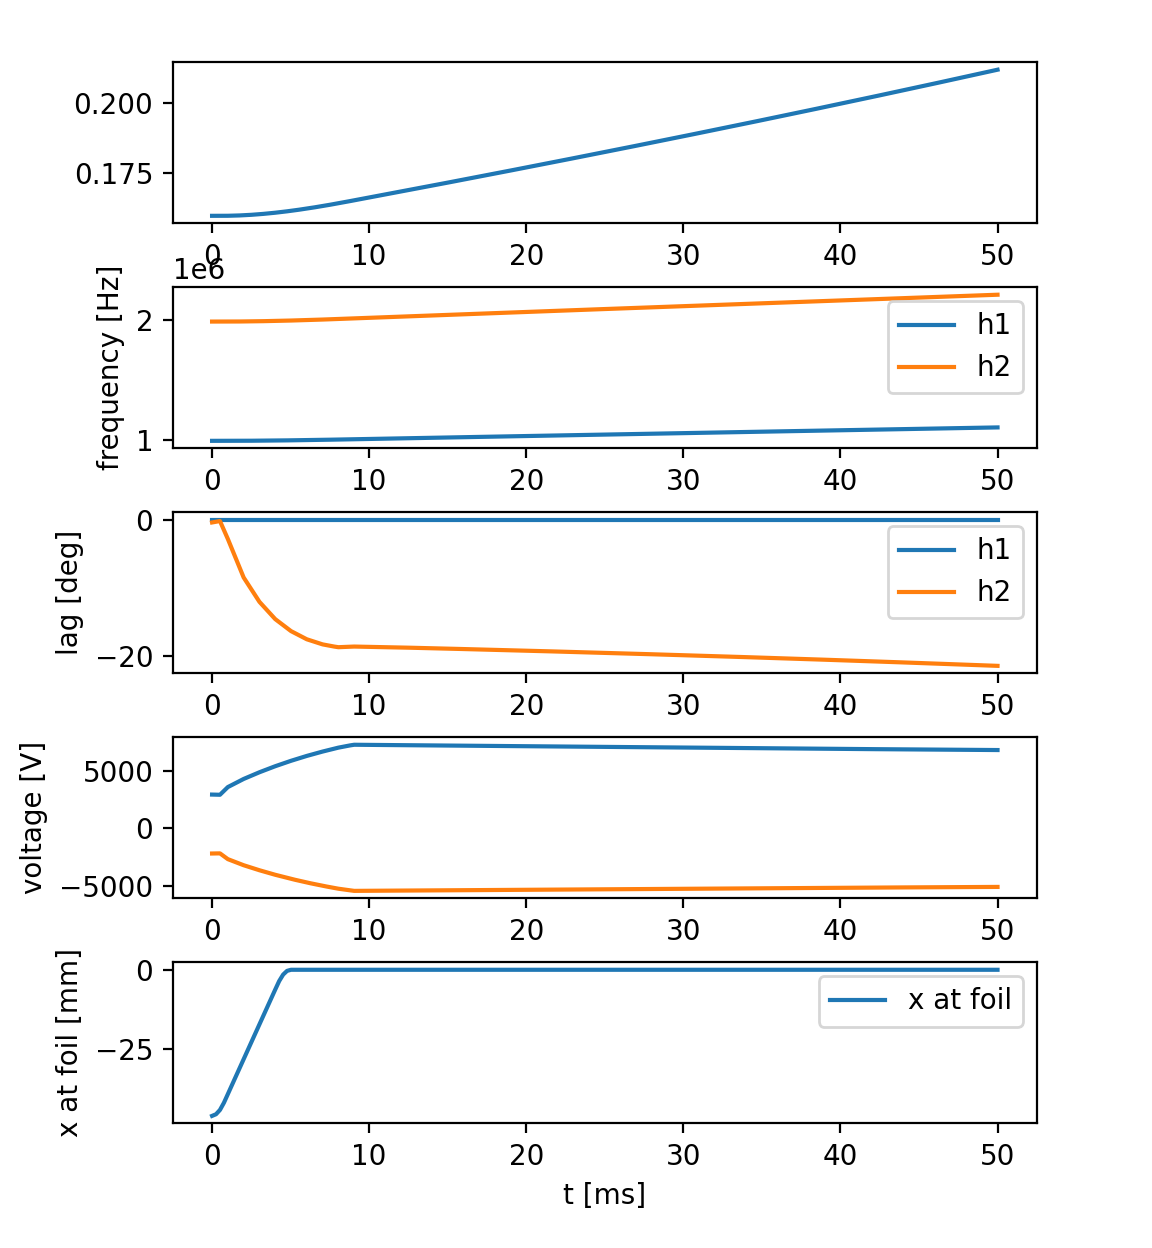

In [21]:
plt.figure(3, figsize=(6.4 * 0.9, 4.8 * 1.3))
sp1 = plt.subplot(5,1,1)
plt.plot(t_check*1e3, e_kin_gev)

sp2 = plt.subplot(5,1,2, sharex=sp1)
plt.plot(t_check*1e3, f_h1, label='h1')
plt.plot(t_check*1e3, f_h2, label='h2')
plt.ylabel('frequency [Hz]')
plt.legend()
                  
plt.subplot(5,1,3, sharex=sp1)
plt.plot(t_check*1e3, lag_h1, label='h1')
plt.plot(t_check*1e3, lag_h2, label='h2')
plt.ylabel('lag [deg]')
plt.legend()

plt.subplot(5,1,4, sharex=sp1)
plt.plot(t_check*1e3, volt_h1, label='h1')
plt.plot(t_check*1e3, volt_h2, label='h2')
plt.ylabel('voltage [V]')

plt.subplot(5,1,5, sharex=sp1)
plt.plot(t_check*1e3, np.array(x_at_foil)*1e3, label='x at foil')
plt.ylabel('x at foil [mm]')

plt.legend()

plt.xlabel('t [ms]')

plt.subplots_adjust(top=.95, bottom=0.1, left=.15, hspace=.6)